<a href="https://colab.research.google.com/github/DungDuong1002/Photo-Colorization/blob/main/Autoencoder_color.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
SIZE = 160
color_img = []
gray_img = []
path = '/content/drive/MyDrive/Landscape Images/color'
files = os.listdir(path)
for i in tqdm(files):
  img1 = cv2.imread(path + '/'+i,1)
# open cv reads images in BGR format so we have to convert it to RGB
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
#resizing image
  img1 = cv2.resize(img1, (SIZE, SIZE))
  img1 = img1.astype('float32') / 255.0
  color_img.append(img_to_array(img1))

  img2 = cv2.imread(path + '/'+i,0)
# open cv reads images in BGR format so we have to convert it to RGB
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
#resizing image
  img2 = cv2.resize(img2, (SIZE, SIZE))
  img2 = img2.astype('float32') / 255.0
  gray_img.append(img_to_array(img2))

100%|██████████| 5500/5500 [17:04<00:00,  5.37it/s]


In [18]:
# defining function to plot images pair
def plot_images_1(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image')
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ')
    plt.imshow(grayscale)
   
    plt.show()

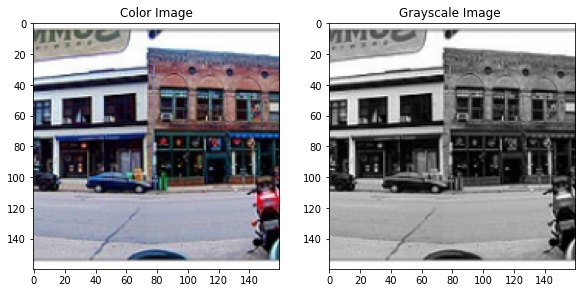

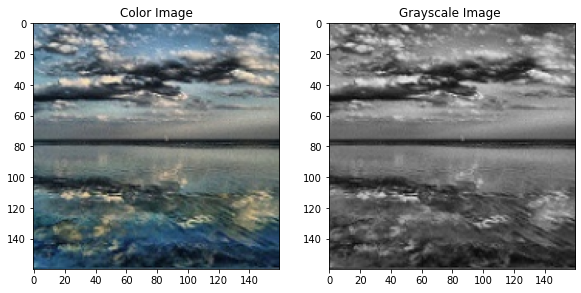

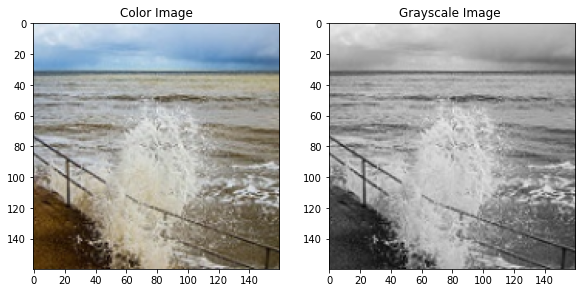

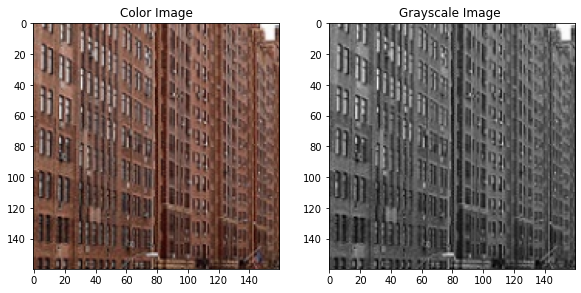

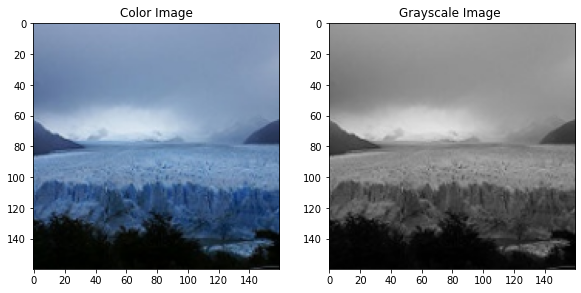

In [20]:
for i in range(5):
     plot_images_1(color_img[i],gray_img[i])

In [6]:
train_gray = gray_img[:5000]
train_color = color_img[:5000]

test_gray = gray_img[5000:]
test_color = color_img[5000:]
# reshaping
train_gray = np.reshape(train_gray,(len(train_gray),SIZE,SIZE,3))
train_color = np.reshape(train_color, (len(train_color),SIZE,SIZE,3))
print('Train color image shape:',train_color.shape)


test_gray = np.reshape(test_gray,(len(test_gray),SIZE,SIZE,3))
test_color = np.reshape(test_color, (len(test_color),SIZE,SIZE,3))
print('Test color image shape:',test_color.shape)

Train color image shape: (5000, 160, 160, 3)
Test color image shape: (500, 160, 160, 3)


In [7]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [8]:
def model():
    #downsampling
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    d5 = down(512,(3,3),True)(d4)
    
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [9]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 80, 80, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 40, 40, 128)  147584      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 20, 20, 256)  296192      ['sequential_1[0][0]']       

In [10]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'mean_absolute_error',
              metrics = ['acc'])

In [11]:
model.fit(train_gray, train_color, epochs = 100,batch_size = 25,verbose = 1)

Epoch 1/100
200/200 [==============================] - 85s 258ms/step - loss: 0.1210 - acc: 0.3931
Epoch 2/100
200/200 [==============================] - 52s 259ms/step - loss: 0.0628 - acc: 0.4591
Epoch 3/100
200/200 [==============================] - 52s 260ms/step - loss: 0.0556 - acc: 0.4743
Epoch 4/100
200/200 [==============================] - 52s 259ms/step - loss: 0.0519 - acc: 0.4872
Epoch 5/100
200/200 [==============================] - 52s 259ms/step - loss: 0.0496 - acc: 0.5014
Epoch 6/100
200/200 [==============================] - 52s 260ms/step - loss: 0.0484 - acc: 0.5107
Epoch 7/100
200/200 [==============================] - 52s 260ms/step - loss: 0.0474 - acc: 0.5232
Epoch 8/100
200/200 [==============================] - 52s 259ms/step - loss: 0.0463 - acc: 0.5348
Epoch 9/100
200/200 [==============================] - 52s 259ms/step - loss: 0.0462 - acc: 0.5314
Epoch 10/100
200/200 [==============================] - 52s 259ms/step - loss: 0.0454 - acc: 0.5446
Epoch 11/

In [13]:
model.evaluate(test_gray,test_color)

16/16 [==============================] - 4s 167ms/step - loss: 0.0457 - acc: 0.5408


[0.04568963125348091, 0.5407694578170776]

In [22]:
# defining function to plot images
def plot_images_2(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image')
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image')
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image')
    plt.imshow(predicted)
   
    plt.show()

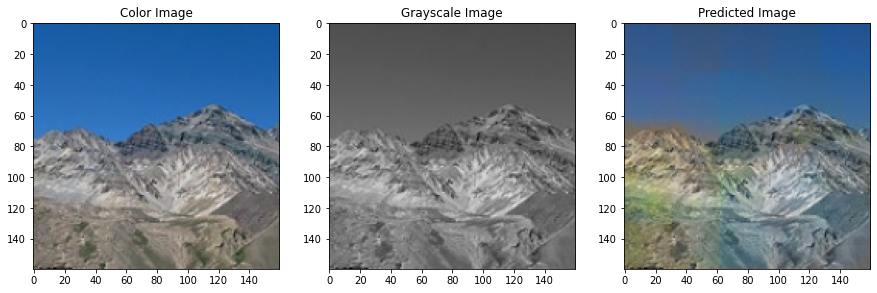

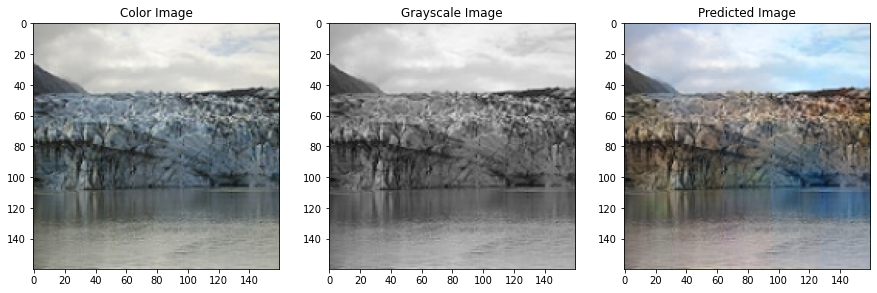

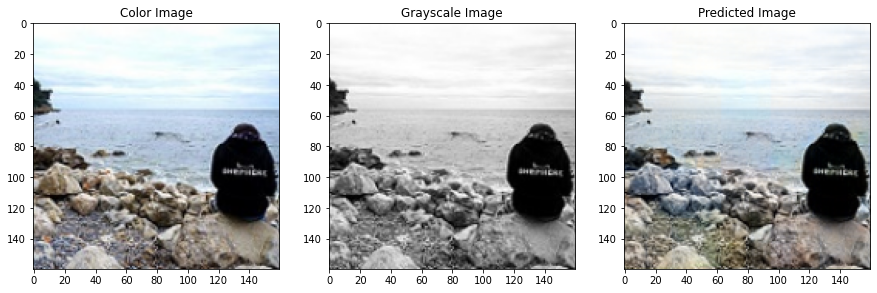

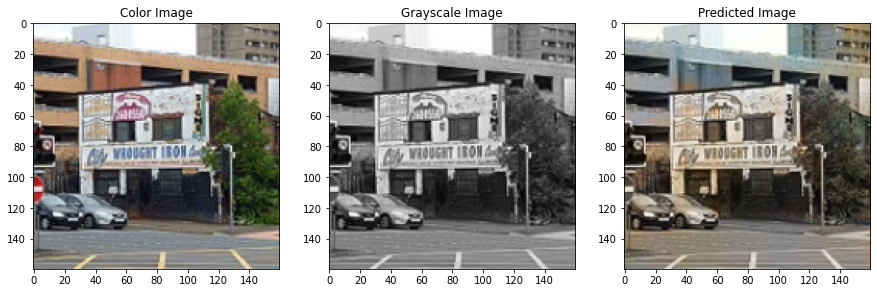

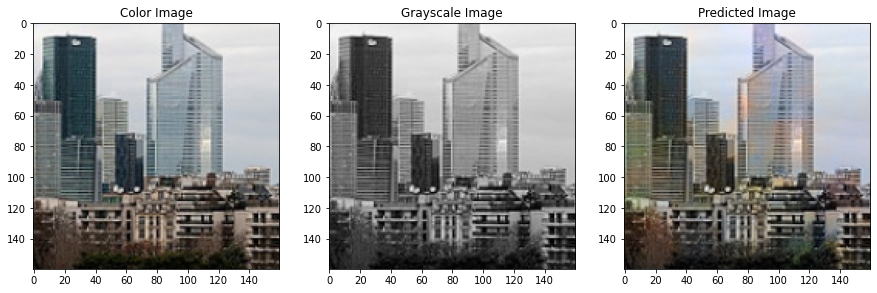

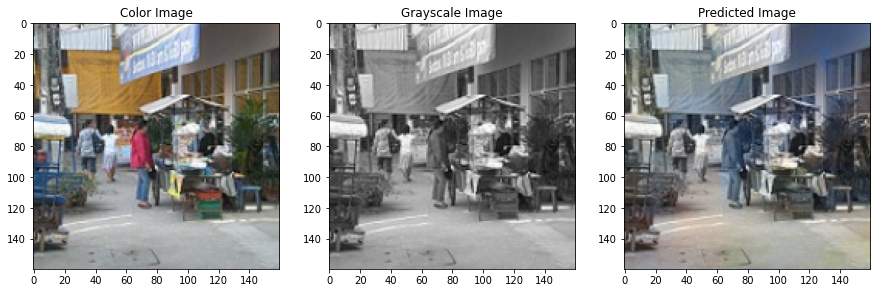

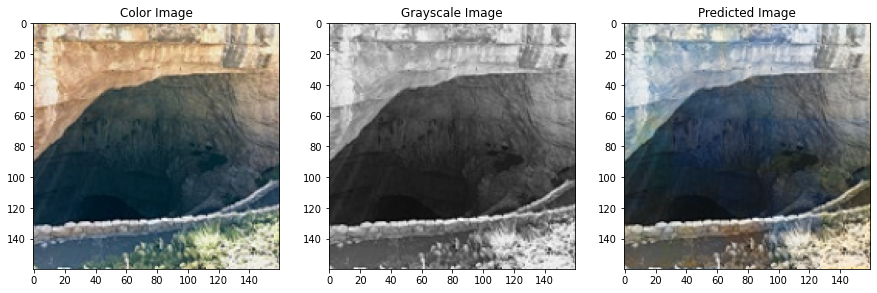

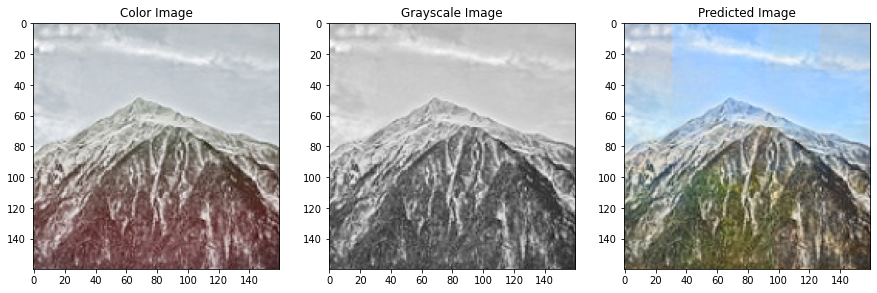

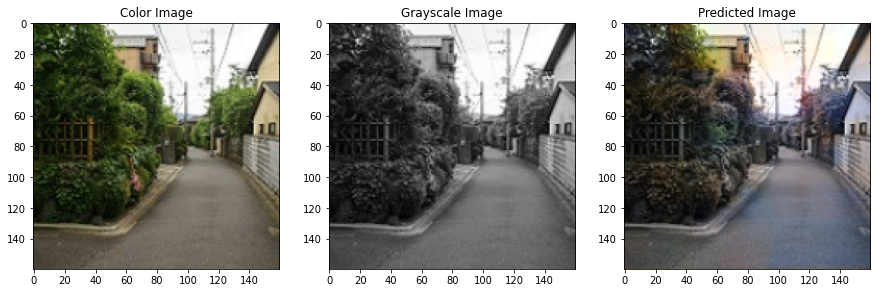

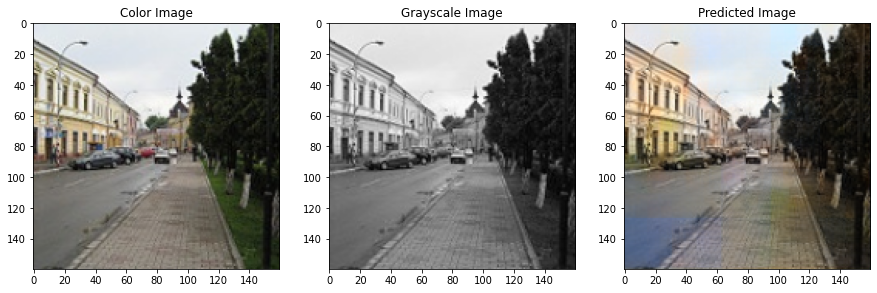

In [25]:
for i in range(20,30):
    predicted = np.clip(model.predict(test_gray[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images_2(test_color[i],test_gray[i],predicted)

In [24]:
model.save('autoencoder_color.h5')